<a href="https://colab.research.google.com/github/eid-osama/Natq/blob/main/FastPitch_MixerTTS_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🗣️ Arabic TTS Demo with FastPitch, MixerTTS, and HiFi-GAN

This notebook demonstrates how to generate high-quality Arabic speech using **FastPitch**, **MixerTTS**, and **HiFi-GAN** from NVIDIA NeMo.

### 📘 Overview
1. **Setup & Imports:** Prepare environment and dependencies.  
2. **Model Loading:** Load pre-trained NeMo TTS models.  
3. **Text Processing:** Convert Arabic text to phonemes.  
4. **Speech Generation:** Generate mel-spectrograms and waveforms.  
5. **Visualization & Playback:** Display and play synthesized audio.


### 🔧 Setup & Imports

In [ ]:
# Install dependencies
!pip install gdown noisereduce
!pip install catt-tashkeel

!git clone https://github.com/nipponjo/tts-arabic-pytorch.git

# Install NeMo
BRANCH = 'main'
!python -m pip install "git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]"

exit() # Optional for restarting the kernel

### Writing the tokenizer class

In [4]:
%%writefile arabic_phoneme_tokenizer.py
import sys
sys.path.append('tts-arabic-pytorch')  # Add the script's directory to Python path
import nemo.collections.common.tokenizers.text_to_speech.tts_tokenizers as tts_tokenizers
import text as txt
class ArabicPhonemeTokenizer(tts_tokenizers.BaseTokenizer):

    def __init__(self):
        self.phonemes = txt.symbols
        # Create phoneme dictionary
        self.phoneme_dict = txt.phon_to_id_
        self.vocab = self.phoneme_dict
        self.itos = list(self.vocab.keys())  # Index-to-string mapping
        self.stoi = self.vocab  # String-to-index mapping
        self.pad = txt.phon_to_id_["_pad_"]
        super().__init__(tokens=self.phoneme_dict)

    def encode(self, text):
        # Convert a phoneme sequence into a list of indices
        tokens = txt.phonemes_to_tokens(text, append_space=False)
        return txt.tokens_to_ids(tokens)

    def decode(self, tokens):
        # Convert a list of indices back into a phoneme sequence
        return ' '.join(txt.ids_to_tokens(tokens))

Writing arabic_phoneme_tokenizer.py


In [5]:
# === Core Imports ===
import sys
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import IPython.display as ipd

# === Utility Imports ===
import gdown
import noisereduce as nr

# === Custom Modules ===
sys.path.append('/content/tts-arabic-pytorch/text/')  # Add script directory to Python path
from phonetise_buckwalter import arabic_to_buckwalter, process_utterance
import arabic_phoneme_tokenizer
import text as txt
from catt_tashkeel import CATTEncoderDecoder

# === NeMo Models ===
from nemo.collections.tts.models import HifiGanModel, FastPitchModel, MixerTTSModel

# === Confirmation ===
print("\n✅ NeMo and all modules successfully loaded!")

W1025 20:06:18.682000 2486 torch/utils/cpp_extension.py:118] No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
[NeMo W 2025-10-25 20:06:39 nemo_logging:405] /usr/local/lib/python3.12/dist-packages/pydub/utils.py:300: SyntaxWarning: invalid escape sequence '\('
      m = re.match('([su]([0-9]{1,2})p?) \(([0-9]{1,2}) bit\)$', token)
    
[NeMo W 2025-10-25 20:06:39 nemo_logging:405] /usr/local/lib/python3.12/dist-packages/pydub/utils.py:301: SyntaxWarning: invalid escape sequence '\('
      m2 = re.match('([su]([0-9]{1,2})p?)( \(default\))?$', token)
    
[NeMo W 2025-10-25 20:06:39 nemo_logging:405] /usr/local/lib/python3.12/dist-packages/pydub/utils.py:310: SyntaxWarning: invalid escape sequence '\('
      elif re.match('(flt)p?( \(default\))?$', token):
    
[NeMo W 2025-10-25 20:06:39 nemo_logging:405] /usr/local/lib/python3.12/dist-packages/pydub/utils.py:314: SyntaxWarning: invalid escape sequence '\('
      elif re.match('(dbl)p?( \(default\))?$', token):
    



✅ NeMo and all modules successfully loaded!


In [10]:
def evaluate_spec_fastpitch_ckpt(spec_gen_model, v_model, text):
    with torch.no_grad():
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.enabled = True
        torch.backends.cudnn.benchmark = False
        if isinstance(spec_gen_model, FastPitchModel):
            parsed = spec_gen_model.parse(str_input=text)
        else:
            parsed = spec_gen_model.parse(text=text)
        spectrogram = spec_gen_model.generate_spectrogram(tokens=parsed)
        # print("spectrogram size :", spectrogram.size())
        audio = v_model.convert_spectrogram_to_audio(spec=spectrogram)

    spectrogram = spectrogram.to('cpu').numpy()[0]
    audio = audio.to('cpu').numpy()[0]
    audio = audio / np.abs(audio).max()
    return audio, spectrogram

def plot_spec_audio(audio, spectrogram, title=""):
    # Plot predicted spectrogram FastPitch
    plt.figure(figsize=(12, 4))
    plt.imshow(spectrogram, origin="lower", aspect="auto", cmap="viridis")
    plt.title(f"Predicted Spectrogram {title}")
    plt.colorbar(format="%+2.0f dB")
    plt.show()

    print(f"Predicted audio {title}:")
    ipd.display(ipd.Audio(audio, rate=22050))

    denoised = nr.reduce_noise(y=audio, sr=22050, y_noise=audio)
    print("Noise Removed:")
    ipd.display(ipd.Audio(1.2 * denoised, rate=22050))

def custom_arabic_to_phones(text, tashkeel=True):
    # Step 1: Convert remaining Arabic to Buckwalter
    if tashkeel:
      ed = CATTEncoderDecoder()
      text = ed.do_tashkeel(text, verbose=False)
      print("Tashkeel output: ", text)
    bw_text = arabic_to_buckwalter(text)
    return process_utterance(bw_text).replace("+ ", "")

In [7]:
!gdown 18MMnP1VSXuxu55TFFBA4JKm5Tv28Lfht # hifigan
!gdown 1G0vVsuxdNeV02dHTvl1VxT4Bw2hVsmYe # fastpitch
!gdown 1XXK5JuHweSq3IGrTQ8MRy7sOoFdcGPeV # mixer-tts

Downloading...
From (original): https://drive.google.com/uc?id=18MMnP1VSXuxu55TFFBA4JKm5Tv28Lfht
From (redirected): https://drive.google.com/uc?id=18MMnP1VSXuxu55TFFBA4JKm5Tv28Lfht&confirm=t&uuid=388a728d-530a-4be4-be92-d6ba8db652a2
To: /content/HifiGan--val_loss=0.3817-epoch=34-last.ckpt.zip
100% 946M/946M [00:10<00:00, 91.3MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1G0vVsuxdNeV02dHTvl1VxT4Bw2hVsmYe
From (redirected): https://drive.google.com/uc?id=1G0vVsuxdNeV02dHTvl1VxT4Bw2hVsmYe&confirm=t&uuid=d57714e7-cba5-489c-9c4d-d03d8887620a
To: /content/FastPitch--val_loss=0.7130-epoch=49-last.ckpt.zip
100% 500M/500M [00:07<00:00, 70.2MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1XXK5JuHweSq3IGrTQ8MRy7sOoFdcGPeV
From (redirected): https://drive.google.com/uc?id=1XXK5JuHweSq3IGrTQ8MRy7sOoFdcGPeV&confirm=t&uuid=613fb71d-3540-4269-ad02-9e5928b5e1d8
To: /content/Mixer-TTS--val_mel_loss=0.7356-epoch=57.ckpt.zip
100% 220M/220M [00:03<00:00, 61.0MB/s

### 🎵 Model Loading


In [8]:
!unzip /content/FastPitch--val_loss=0.7130-epoch=49-last.ckpt.zip
!unzip /content/Mixer-TTS--val_mel_loss=0.7356-epoch=57.ckpt.zip
!unzip /content/HifiGan--val_loss=0.3817-epoch=34-last.ckpt.zip

Archive:  /content/FastPitch--val_loss=0.7130-epoch=49-last.ckpt.zip
  inflating: FastPitch--val_loss=0.7130-epoch=49-last.ckpt  
Archive:  /content/Mixer-TTS--val_mel_loss=0.7356-epoch=57.ckpt.zip
  inflating: Mixer-TTS--val_mel_loss=0.7356-epoch=57.ckpt  
Archive:  /content/HifiGan--val_loss=0.3817-epoch=34-last.ckpt.zip
  inflating: HifiGan--val_loss=0.3817-epoch=34-last.ckpt  


In [ ]:
fastpitch_path = "/content/FastPitch--val_loss=0.7130-epoch=49-last.ckpt"
mixer_path     = "/content/Mixer-TTS--val_mel_loss=0.7356-epoch=57.ckpt"
hfg_path       = "/content/HifiGan--val_loss=0.3817-epoch=34-last.ckpt"


fastpitch = FastPitchModel.load_from_checkpoint(checkpoint_path=fastpitch_path).eval()#.cuda()
mixer     = MixerTTSModel.load_from_checkpoint(checkpoint_path=mixer_path).eval()#.cuda()
vocoder   = HifiGanModel.load_from_checkpoint(checkpoint_path=hfg_path).eval()#.cuda()


### 📊 Generation & Visualization

📥 Downloading ed_model models...


Downloading: 85.9MB [00:00, 142MB/s]                            


📦 Extracting ed_model models...
✅ ed_model models downloaded and extracted successfully!
✅ Loaded model successfully!
Tashkeel output:  أَنْ يَعِيشَ لَحْظَةَ التَّكْوِينِ الْعِلْمِيِّ فِي عَصْرِ ثَوْرَةِ نُظُمِ الِاتِّصَالَاتِ وَشَبَكَاتِ التَّوَاصُلِ
Phonemes : < a n y a E ii0 $ a l a H Z A t A tt a k w ii0 n i0 l E i0 l m ii0 y i0 f ii0 E A S r i0 ^ a w r a t i0 n U0 Z U0 m i0 l i0 tt I0 S AA l aa t i0 w a $ a b a k aa t i0 tt a w AA S U0 l i0


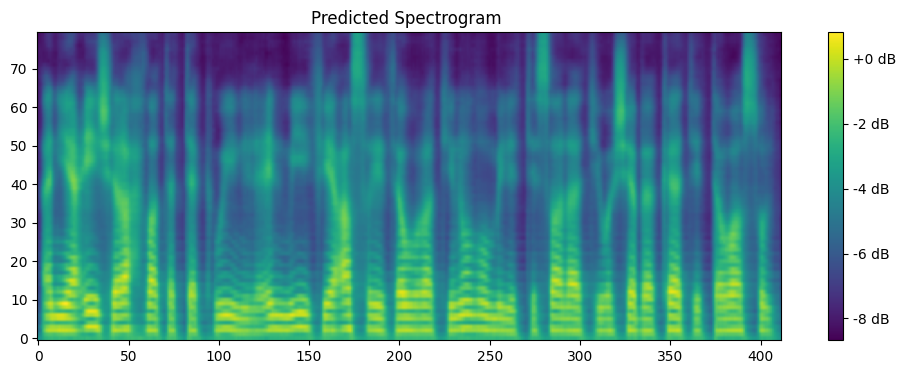

Predicted audio :


Noise Removed:


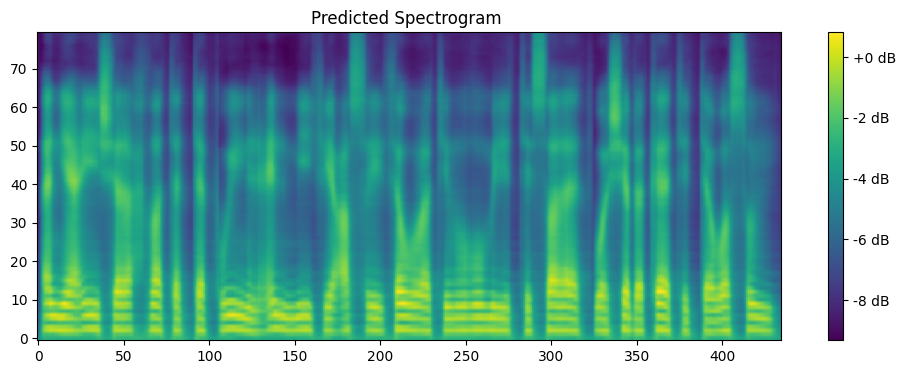

Predicted audio :


Noise Removed:


In [11]:
arabic_text = " أَنْ يَعيشَ لَحْظَةَ التَّكْوينِ العِلْميِّ في عَصْرِ ثَوْرَةِ نُظُمِ الِاتِّصالاتِ وَشَبَكاتِ التَّواصُلُ"

phones = custom_arabic_to_phones(arabic_text)
print("Phonemes :", phones)

seed = 20
# Predict audio and spectrogram
audio_fp, pred_spec_fb = evaluate_spec_fastpitch_ckpt(fastpitch, vocoder, phones)
audio_mix, pred_spec_mix = evaluate_spec_fastpitch_ckpt(mixer, vocoder, phones)

# Plot predicted spectrogram FastPitch
plot_spec_audio(audio_fp, pred_spec_fb)

# Plot predicted spectrogram Mixer-TTS
plot_spec_audio(audio_mix, pred_spec_mix)